Important Note: This notebook will not run as we have not provided the necessary data files. If you have access to PPMI and would like to use the exact model used in 'Discovery of Parkinson’s disease states using a machine learning approach', please reach out to the authors.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lifelines
import statsmodels

from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from sklearn.externals import joblib
from scikit_posthocs import posthoc_nemenyi as pn

In [3]:
train_data = # import training data
test_data = # import PPMI testing data
pdbp_arr = # import PBDP testing data

tmax = 31
xpre = train_data['target']
xpre_test = test_data['target']

remove_idx_train = np.where(np.sum(np.isnan(xpre[:,:,0]), axis=1) == tmax-1)
xpre = np.delete(xpre, remove_idx_train, 0)

remove_idx_test = np.where(np.sum(np.isnan(xpre_test[:,:,0]), axis=1) == tmax-1)
xpre_test = np.delete(xpre_test, remove_idx_test, 0)

In [4]:
PIOHMM = # import disease progression model

MU = PIOHMM['params']['mu'].numpy()

In [5]:
model = # import constrative latent variable model
w = model['W']
order_w = np.argsort(np.linalg.norm(w, axis=1))
order_w = np.flipud(order_w)
w = w[order_w, :]
w = w[:28,:].T

In [6]:
idx = []
n, t, d = xpre.shape

time_mask = np.ones((n,t))
for i in range(n):
    ind = np.where(~np.isnan(xpre[i, :, 0]))[0][-1] + 1
    idx.append(ind)
    time_mask[i, ind:] = 0


idx = []
n, t, d = xpre_test.shape

time_mask_test = np.ones((n,t))
for i in range(n):
    ind = np.where(~np.isnan(xpre_test[i, :, 0]))[0][-1] + 1
    idx.append(ind)
    time_mask_test[i, ind:] = 0
    
n, t, d = pdbp_arr[0]['data'].shape

time_mask_pdbp = np.ones((n,t))
for i in range(n):
    ind = np.where(~np.isnan(pdbp_arr[0]['data'][i, :, 0]))[0][-1] + 1
    time_mask_pdbp[i, ind:] = 0

### Figure 2

In [7]:
flip_idx = np.concatenate((np.ones(26), [-1], np.ones(33), [-1], [1], [-1], np.ones(7), -np.ones(5), np.ones(2), -np.ones(5)))

titles = ['Cog. Impairment','Hall. and Pysychosis', 'Depressed Mood', 'Anxious Mood',
          'Apathy', 'DDS', 'Sleep Problems', 'Daytime Sleep', 'Pain', 'Urinary Prob',
          'Constipation Prob.', 'Light Head.', 'Fatigue', 'Speech', 'Saliva and Drool',
          'Chew and Swallow', 'Eating', 'Dressing', 'Hygiene', 'Handwriting', 'Hobbies',
          'Turning in Bed', 'Tremor', 'Getting Out Bed', 'Walk and Balance', 'Freezing', 'MSE-ADL',
          'Speech', 'Facial Expression', 'Rigidity - N', 'Rigidty - RU', 'Rigidity - LU', 'Rigidity - RL',
         'Rigidity - LL', 'Finger Tap - R', 'Finger Tap - L', 'Hand Move - R', 'Hand Move - L', 'Pro.-Sup. Hand - R',
         'Pro.-Sup. Hand - L', 'Toe Tap - R', 'Toe Tap - L', 'Leg Agility - R', 'Leg Agility - L', 'Arising',
         'Gait', 'Freezing Gait', 'Postural Stability', 'Posture', 'Body Bradykinesia', 'P. Tremor Hands - R', 
         'P. Tremor Hands - L', 'K. Tremor Hands - R', 'K. Tremor Hands - L', 'R. Tremor Amp - RU', 'R. Tremor Amp - LU',
         'R. Tremor Amp - RL', 'R. Tremor Amp - LL', 'R. Tremor Amp - LJ', 'Cons. R. Tremor',
         'SDMT', 'STAI', 'SFT', 'SCOPA', 'REM Sleep', 'QUIP A', 'QUIP B', 'QUIP C', 'QUIP D', 'QUIP E',
         'MOCA', 'LNS', 'HVLT Recall', 'HVLT', 'HVLT Retention', 'Geriatric Depress.', 'Epsworth Sleep',
         'BJLOT', 'Caudate R', 'Caudate L', 'Putamen R', 'Putamen L']

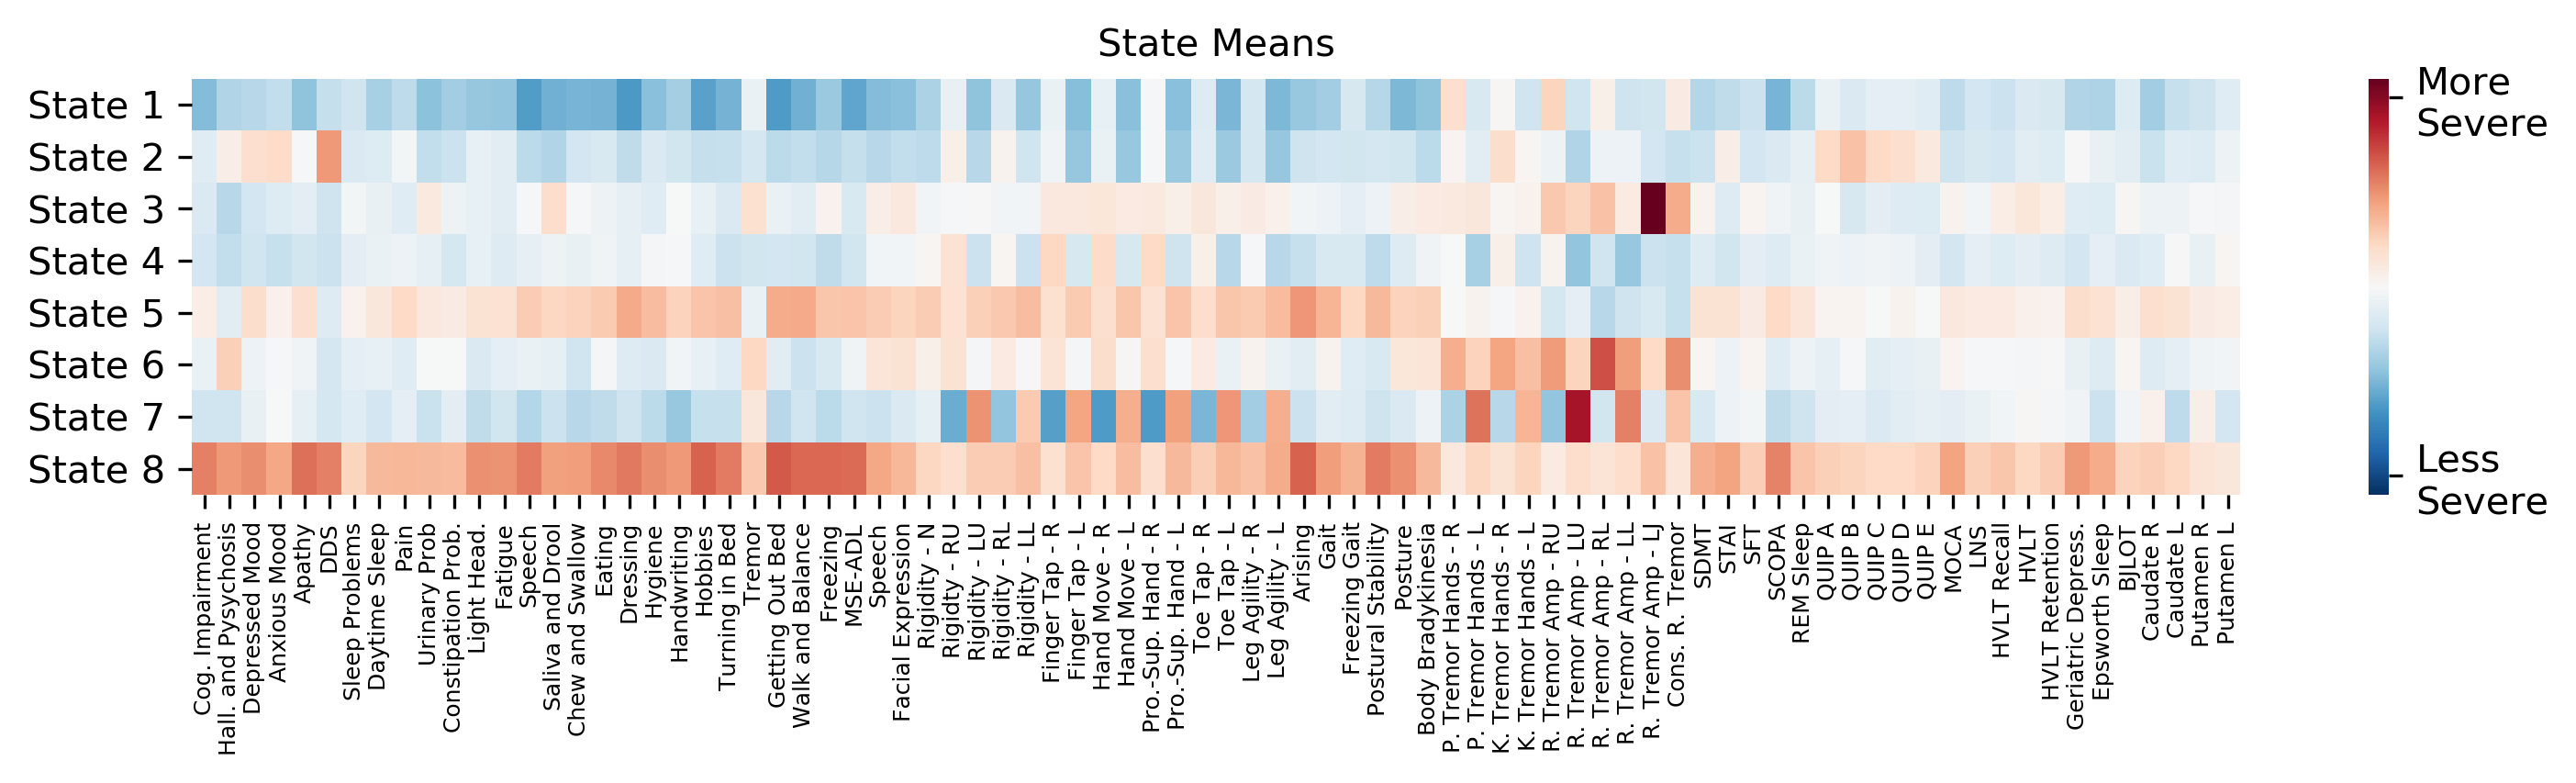

In [8]:
fig, ax = plt.subplots(1,1,dpi=300)
fig.set_size_inches(12,2)
sns.heatmap(flip_idx[np.newaxis, :]*np.matmul(MU, w.T),cmap='RdBu_r',ax=ax,vmin=-1.1, vmax=1.1)
ax.set_xticks(np.arange(0.5,82.5))
ax.set_xticklabels(titles,rotation=90,fontsize=6)
ax.set_yticks(np.arange(0.5,8,1))
ax.set_yticklabels(['State 1', 'State 2', 'State 3', 'State 4', 'State 5', 'State 6', 'State 7', 'State 8'],rotation=360,fontsize=10)
ax.set_title('State Means', fontsize=10)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,1])
cbar.set_ticklabels(['Less\nSevere', 'More\nSevere'])

fig.savefig('figure2b.eps', format='eps', dpi=300)

### Figure 3

In [9]:
PIOHMM_PPMI_test= # import PPMI test results for PIOHMM
PIOHMM_PDBP = # import PDBP test results for PIOHMM

HMM_PPMI_test = # import PPMI test results for HMM
HMM_PDBP = # import PDBP test results for HMM

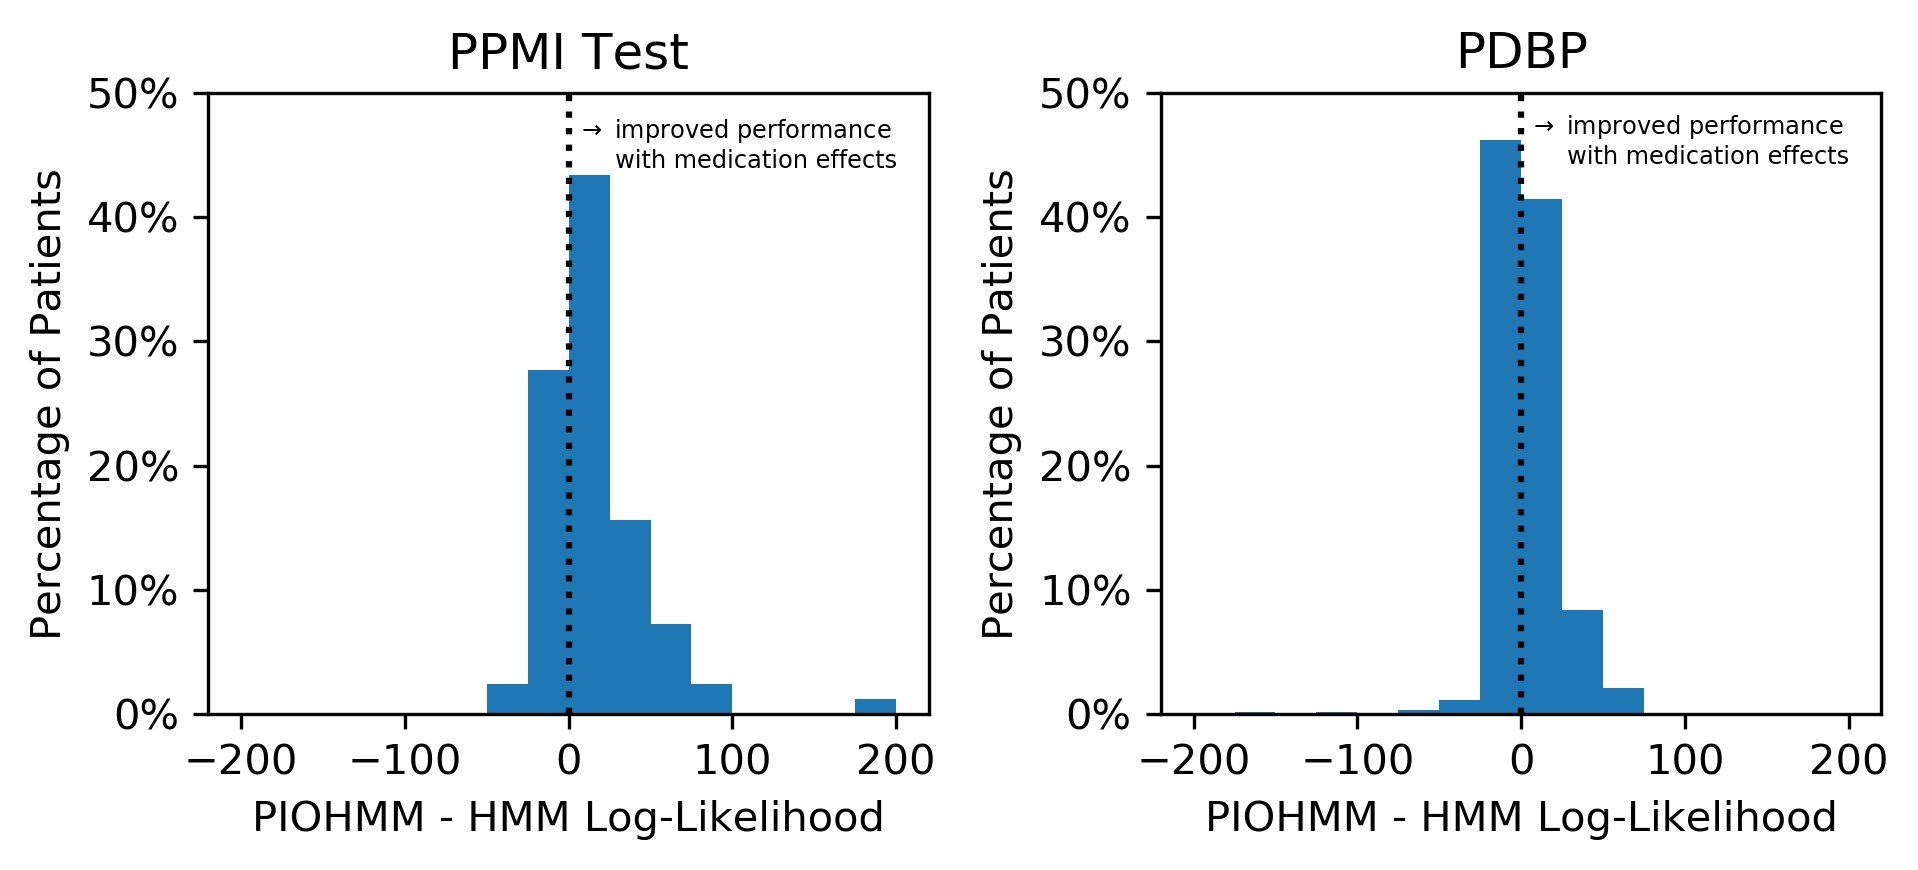

In [10]:
fig, ax = plt.subplots(1,2,dpi=300)
fig.set_size_inches(6.5, 3)
ax[0].hist(PIOHMM_PPMI_test['test_px'].detach().numpy()-HMM_PPMI_test['test_pX'].numpy(),bins = np.arange(-200,225,25))
ax[0].plot(np.zeros(43), np.arange(43),'k:')
ax[0].set_ylim([0,41.5])
ax[0].set_yticks([0,8.3,16.6,24.9,33.2,41.5])
ax[0].set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
ax[0].annotate(r"$\rightarrow$ improved performance" +"\n" + "     with medication effects", (5,36.5), fontsize='xx-small')
ax[0].set_xlabel('PIOHMM - HMM Log-Likelihood')
ax[0].set_ylabel('Percentage of Patients')
ax[0].set_title('PPMI Test')

ax[1].hist(PIOHMM_PDBP['test_px'].detach().numpy() - HMM_PDBP['px_pdbp'].numpy(),bins = np.arange(-200,225,25))
ax[1].plot(np.zeros(306), np.arange(306),'k:')
ax[1].set_ylim([0,305])
ax[1].set_yticks([0,61,122,183,244,305])
ax[1].set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
ax[1].annotate(r"$\rightarrow$ improved performance" +"\n" + "     with medication effects", (5,270), fontsize='xx-small')
ax[1].set_xlabel('PIOHMM - HMM Log-Likelihood')
ax[1].set_ylabel('Percentage of Patients')
ax[1].set_title('PDBP')

fig.tight_layout()

fig.savefig('figure3.eps', format='eps', dpi=300)

### Figure 4

In [11]:
final_time_train = time_mask[:,:21].sum(axis=1)
final_time_test = time_mask_test[:,:21].sum(axis=1)
final_time_pdbp = time_mask_pdbp[:,:12].sum(axis=1)

In [12]:
# import most probable state assingments
data = # import PPMI mps
pdbp = # import pdbp MPS

In [13]:
mps_train = data['mps']
mps_test = data['mps_test']
mps_pdbp = pdbp['mps_pdbp']

In [14]:
# number of samples
n_train = mps_train.shape[0]
n_test = mps_test.shape[0]
n_pdbp = mps_pdbp.shape[0]

In [15]:
tt7_train = np.zeros(n_train)
tt7_test = np.zeros(n_test)
tt7_pdbp = np.zeros(n_pdbp)

In [16]:
obs_train = np.ones(n_train)
obs_test = np.ones(n_test)
obs_pdbp = np.ones(n_pdbp)

In [17]:
for i in range(n_train):
    if np.where(mps_train[i,:21]==7)[0].size>0:
        tt7_train[i] = np.where(mps_train[i,:21]==7)[0][0]
    else:
        tt7_train[i] = final_time_train[i]
        obs_train[i] = 0

In [18]:
for i in range(n_test):
    if np.where(mps_test[i,:21]==7)[0].size>0:
        tt7_test[i] = np.where(mps_test[i,:21]==7)[0][0]
    else:
        tt7_test[i] = final_time_test[i]
        obs_test[i] = 0

In [19]:
for i in range(n_pdbp):
    if np.where(mps_pdbp[i,:13]==7)[0].size>0:
        tt7_pdbp[i] = np.where(mps_pdbp[i,:12]==7)[0][0]
    else:
        tt7_pdbp[i] = final_time_pdbp[i]
        obs_pdbp[i] = 0

In [20]:
df_train = pd.DataFrame({'IniState': mps_train[:,0], 'TT7': tt7_train, 'TotalTime': final_time_train, 'observed': obs_train*1})
df_test = pd.DataFrame({'IniState': mps_test[:,0], 'TT7': tt7_test, 'TotalTime': final_time_test, 'observed': obs_test*1})
df_pdbp = pd.DataFrame({'IniState': mps_pdbp[:,0], 'TT7': tt7_pdbp, 'TotalTime':final_time_pdbp, 'observed': obs_pdbp})

In [21]:
km_colors = ['lightseagreen', 'gold', 'thistle', 'salmon', 'steelblue', 'orange', 'yellowgreen', 'lightpink']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


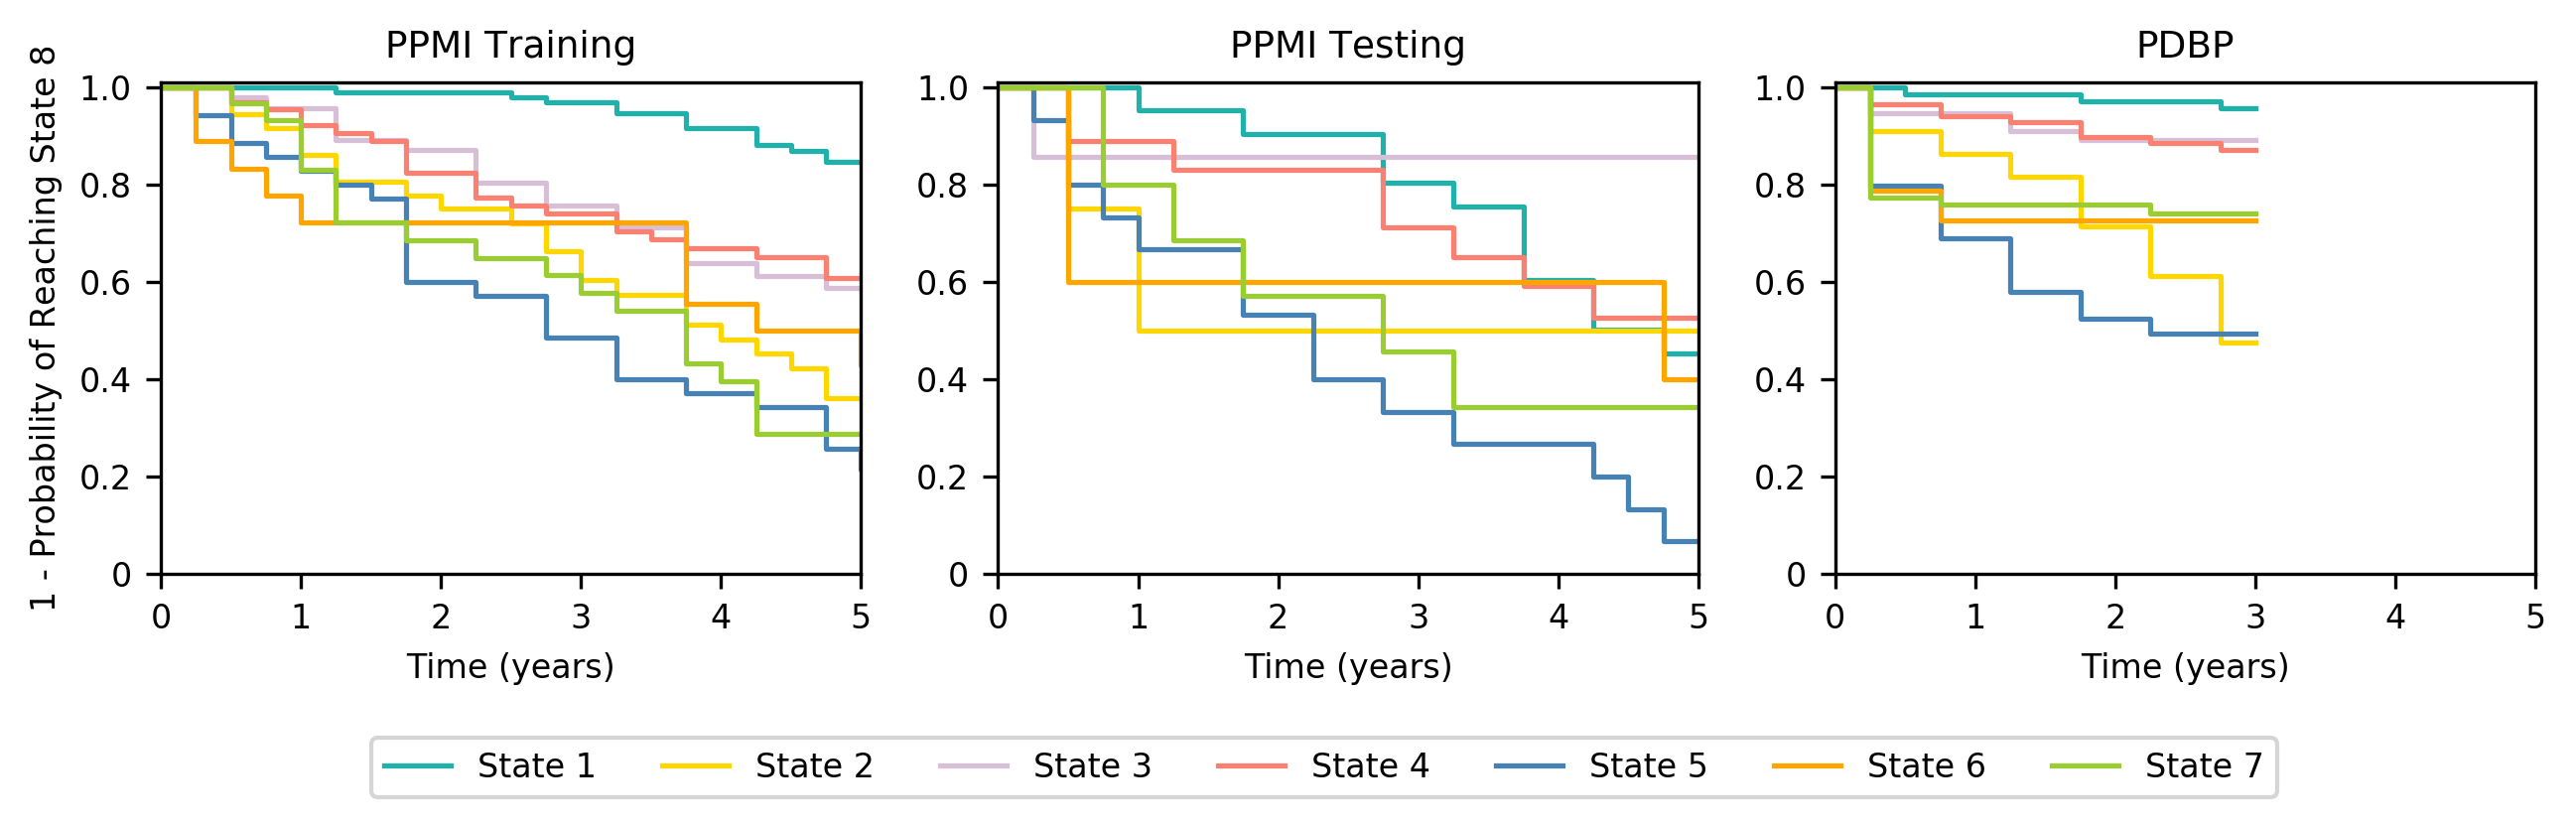

In [22]:
fig, ax = plt.subplots(1,3,dpi=300)
fig.set_size_inches(8.75,2.5)
for i in range(7):
    kmf = lifelines.KaplanMeierFitter()
    

    kmf.fit(df_train[df_train.IniState==i].TT7, event_observed=df_train[df_train.IniState==i].observed)
    kmf.plot_survival_function(ax=ax[0], ci_show=False, lw=1.25, color=km_colors[i], legend=False)

    
for i in range(7):
    kmf = lifelines.KaplanMeierFitter()
    

    kmf.fit(df_test[df_test.IniState==i].TT7, event_observed=df_test[df_test.IniState==i].observed)
    kmf.plot_survival_function(ax=ax[1], ci_show=False, color=km_colors[i], lw=1.25, legend=False, label = 'State ' + str(i+1))
    
        
for i in range(7):
    kmf = lifelines.KaplanMeierFitter()
    

    kmf.fit(df_pdbp[df_pdbp.IniState==i].TT7, event_observed=df_pdbp[df_pdbp.IniState==i].observed)
    kmf.plot_survival_function(ax=ax[2], ci_show=False, lw=1.25,color=km_colors[i], legend=False)
    


ax[0].set_xlim([0,20])
ax[0].set_xticks([0,4,8,12,16,20])
ax[0].set_xticklabels([0,1,2,3,4,5], fontsize=8)
ax[0].set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
ax[0].set_ylim([0,1.01])
ax[0].set_ylabel('1 - Probability of Reaching State 8', fontsize=8)
ax[0].set_xlabel('Time (years)', fontsize=8)
ax[0].set_title('PPMI Training', fontsize=9)


ax[1].set_xlim([0,20])
ax[1].set_xticks([0,4,8,12,16,20])
ax[1].set_xticklabels([0,1,2,3,4,5], fontsize=8)
ax[1].set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax[1].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
ax[1].set_ylim([0,1.01])
ax[1].set_xlabel('Time (years)', fontsize=8)
ax[1].set_title('PPMI Testing', fontsize=9)


ax[2].set_xlim([0,20])
ax[2].set_xticks([0,4,8,12,16,20])
ax[2].set_xticklabels([0,1,2,3,4,5], fontsize=8)
ax[2].set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
ax[2].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=8)
ax[2].set_ylim([0,1.01])
ax[2].set_xlabel('Time (years)', fontsize=8)
ax[2].set_title('PDBP',fontsize=9)


fig.tight_layout()

ax[1].legend(bbox_to_anchor=(1.85,-0.3),ncol=8, fontsize=8)

fig.savefig('Figure4.eps', format='eps', dpi=300)

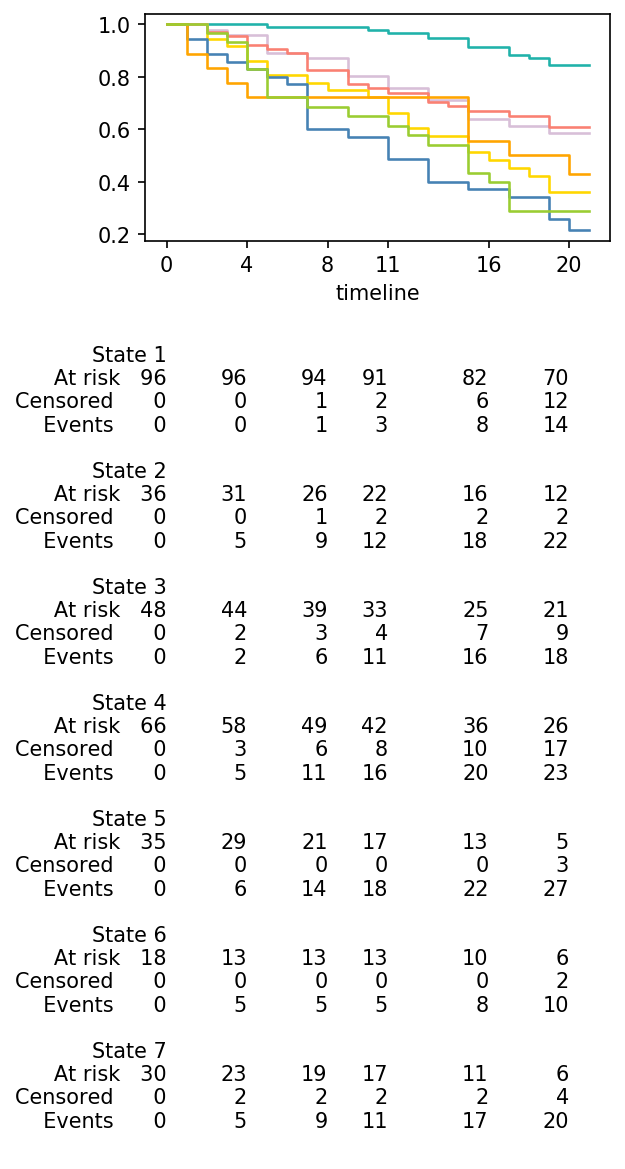

In [23]:
fig, ax = plt.subplots(1,1,dpi=150)
fig.set_size_inches(4,2)

kmf1 = lifelines.KaplanMeierFitter()
kmf2 = lifelines.KaplanMeierFitter()
kmf3 = lifelines.KaplanMeierFitter()
kmf4 = lifelines.KaplanMeierFitter()
kmf5 = lifelines.KaplanMeierFitter()
kmf6 = lifelines.KaplanMeierFitter()
kmf7 = lifelines.KaplanMeierFitter()

kmf1.fit(df_train[df_train.IniState==0].TT7, event_observed=df_train[df_train.IniState==0].observed, label='State 1')
kmf1.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[0], legend=False)

kmf2.fit(df_train[df_train.IniState==1].TT7, event_observed=df_train[df_train.IniState==1].observed, label='State 2')
kmf2.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[1], legend=False)

kmf3.fit(df_train[df_train.IniState==2].TT7, event_observed=df_train[df_train.IniState==2].observed, label='State 3')
kmf3.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[2], legend=False)

kmf4.fit(df_train[df_train.IniState==3].TT7, event_observed=df_train[df_train.IniState==3].observed, label='State 4')
kmf4.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[3], legend=False)

kmf5.fit(df_train[df_train.IniState==4].TT7, event_observed=df_train[df_train.IniState==4].observed, label='State 5')
kmf5.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[4], legend=False)

kmf6.fit(df_train[df_train.IniState==5].TT7, event_observed=df_train[df_train.IniState==5].observed, label='State 6')
kmf6.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[5], legend=False)

kmf7.fit(df_train[df_train.IniState==6].TT7, event_observed=df_train[df_train.IniState==6].observed, label='State 7')
kmf7.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[6], legend=False)

ax.set_xticks([0,4,8,11,16,20])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, kmf6, kmf7, ax = ax)
    

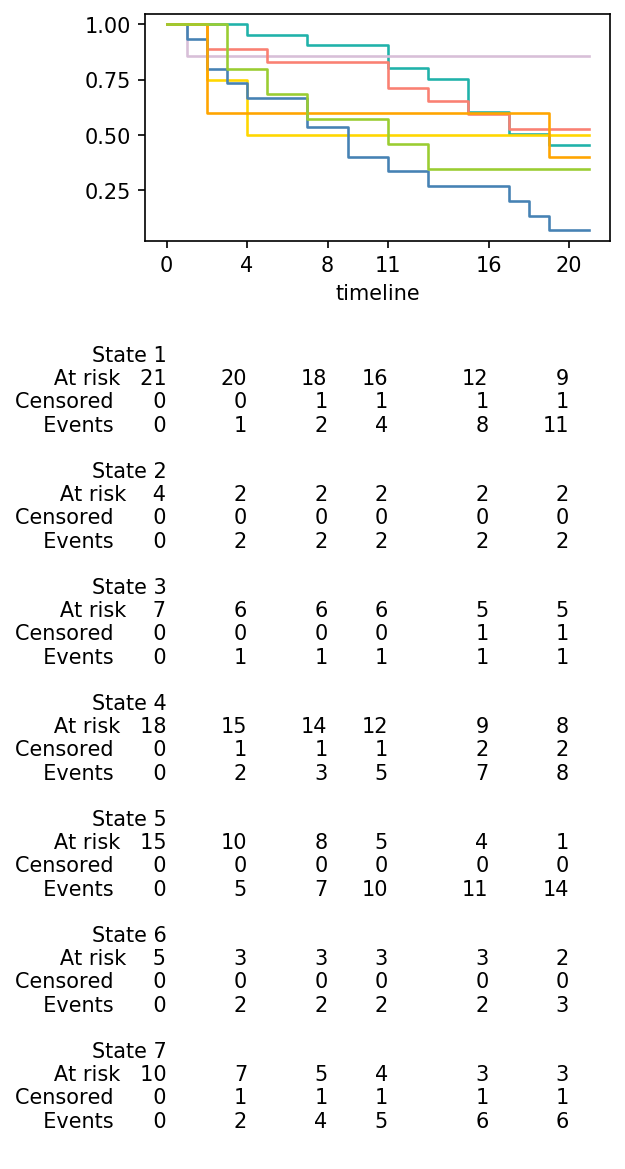

In [24]:
fig, ax = plt.subplots(1,1,dpi=150)
fig.set_size_inches(4,2)

kmf1 = lifelines.KaplanMeierFitter()
kmf2 = lifelines.KaplanMeierFitter()
kmf3 = lifelines.KaplanMeierFitter()
kmf4 = lifelines.KaplanMeierFitter()
kmf5 = lifelines.KaplanMeierFitter()
kmf6 = lifelines.KaplanMeierFitter()
kmf7 = lifelines.KaplanMeierFitter()

kmf1.fit(df_test[df_test.IniState==0].TT7, event_observed=df_test[df_test.IniState==0].observed, label='State 1')
kmf1.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[0], legend=False)

kmf2.fit(df_test[df_test.IniState==1].TT7, event_observed=df_test[df_test.IniState==1].observed, label='State 2')
kmf2.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[1], legend=False)

kmf3.fit(df_test[df_test.IniState==2].TT7, event_observed=df_test[df_test.IniState==2].observed, label='State 3')
kmf3.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[2], legend=False)

kmf4.fit(df_test[df_test.IniState==3].TT7, event_observed=df_test[df_test.IniState==3].observed, label='State 4')
kmf4.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[3], legend=False)

kmf5.fit(df_test[df_test.IniState==4].TT7, event_observed=df_test[df_test.IniState==4].observed, label='State 5')
kmf5.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[4], legend=False)

kmf6.fit(df_test[df_test.IniState==5].TT7, event_observed=df_test[df_test.IniState==5].observed, label='State 6')
kmf6.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[5], legend=False)

kmf7.fit(df_test[df_test.IniState==6].TT7, event_observed=df_test[df_test.IniState==6].observed, label='State 7')
kmf7.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[6], legend=False)

ax.set_xticks([0,4,8,11,16,20])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, kmf6, kmf7, ax = ax)
    

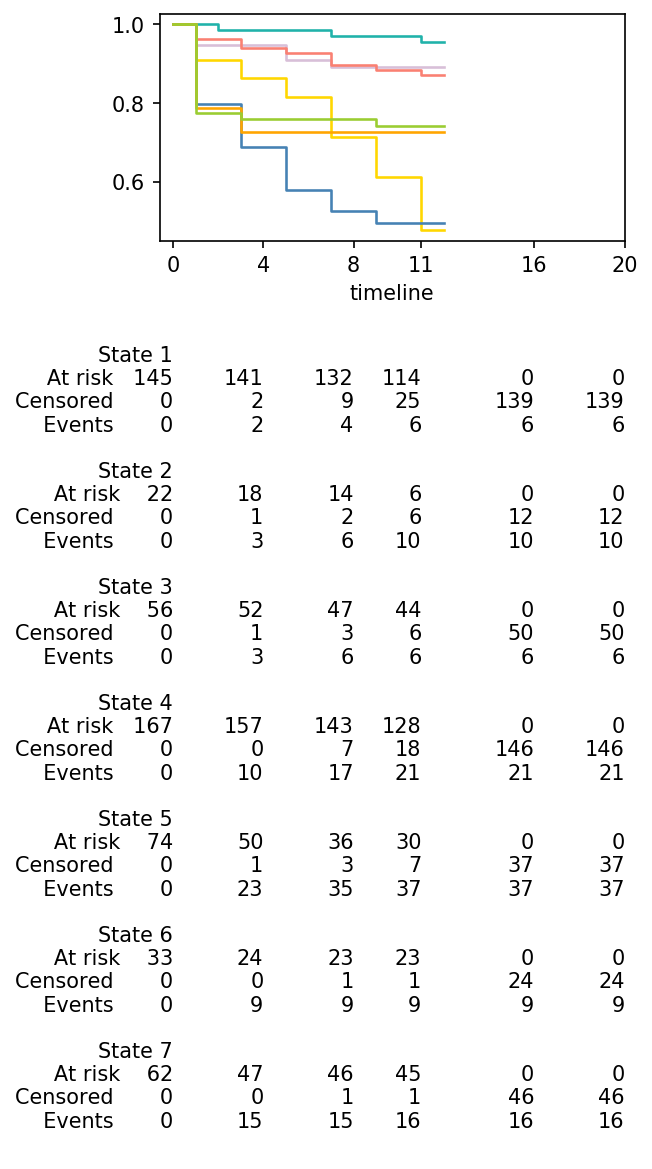

In [25]:
fig, ax = plt.subplots(1,1,dpi=150)
fig.set_size_inches(4,2)

kmf1 = lifelines.KaplanMeierFitter()
kmf2 = lifelines.KaplanMeierFitter()
kmf3 = lifelines.KaplanMeierFitter()
kmf4 = lifelines.KaplanMeierFitter()
kmf5 = lifelines.KaplanMeierFitter()
kmf6 = lifelines.KaplanMeierFitter()
kmf7 = lifelines.KaplanMeierFitter()

kmf1.fit(df_pdbp[df_pdbp.IniState==0].TT7, event_observed=df_pdbp[df_pdbp.IniState==0].observed, label='State 1')
kmf1.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[0], legend=False)

kmf2.fit(df_pdbp[df_pdbp.IniState==1].TT7, event_observed=df_pdbp[df_pdbp.IniState==1].observed, label='State 2')
kmf2.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[1], legend=False)

kmf3.fit(df_pdbp[df_pdbp.IniState==2].TT7, event_observed=df_pdbp[df_pdbp.IniState==2].observed, label='State 3')
kmf3.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[2], legend=False)

kmf4.fit(df_pdbp[df_pdbp.IniState==3].TT7, event_observed=df_pdbp[df_pdbp.IniState==3].observed, label='State 4')
kmf4.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[3], legend=False)

kmf5.fit(df_pdbp[df_pdbp.IniState==4].TT7, event_observed=df_pdbp[df_pdbp.IniState==4].observed, label='State 5')
kmf5.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[4], legend=False)

kmf6.fit(df_pdbp[df_pdbp.IniState==5].TT7, event_observed=df_pdbp[df_pdbp.IniState==5].observed, label='State 6')
kmf6.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[5], legend=False)

kmf7.fit(df_pdbp[df_pdbp.IniState==6].TT7, event_observed=df_pdbp[df_pdbp.IniState==6].observed, label='State 7')
kmf7.plot_survival_function(ax=ax, ci_show=False, lw=1.25, color=km_colors[6], legend=False)

ax.set_xticks([0,4,8,11,16,20])
add_at_risk_counts(kmf1, kmf2, kmf3, kmf4, kmf5, kmf6, kmf7, ax = ax)
    

In [26]:
# calculate pairwise logrank tests
lr_train = np.zeros((6,6,))
lr_test = np.zeros((6,6))
lr_pdbp = np.zeros((6,6))
for i in range(6):
    for j in range(i+1,7):
        lr_train[i,j-1] = logrank_test(df_train[df_train.IniState==i].TT7,  df_train[df_train.IniState==j].TT7, df_train[df_train.IniState==i].observed, df_train[df_train.IniState==j].observed, alpha=0.95).p_value
        lr_test[i,j-1] = logrank_test(df_test[df_test.IniState==i].TT7,  df_test[df_test.IniState==j].TT7, df_test[df_test.IniState==i].observed, df_test[df_test.IniState==j].observed, alpha=0.95).p_value
        lr_pdbp[i,j-1] = logrank_test(df_pdbp[df_pdbp.IniState==i].TT7, df_pdbp[df_pdbp.IniState==j].TT7, df_pdbp[df_pdbp.IniState==i].observed, df_pdbp[df_pdbp.IniState==j].observed, alpha=0.95).p_value

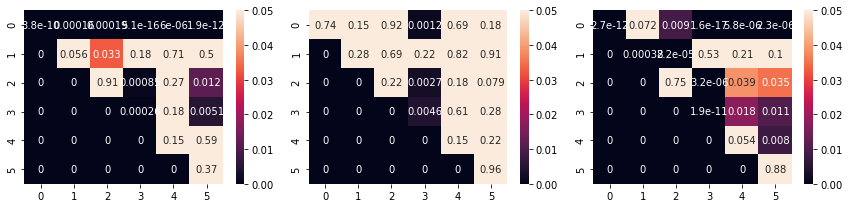

In [27]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(12,3)
sns.heatmap(lr_train,annot=True,vmax=0.05,ax = axs[0])
sns.heatmap(lr_test,annot=True,vmax=0.05,ax = axs[1])
sns.heatmap(lr_pdbp,annot=True,vmax=0.05,ax = axs[2])

fig.tight_layout()

In [28]:
## Look at adjusted results using Benjamini/Hochberg FDR correction
train_pvals_corr = np.zeros(lr_train.shape)
for j in range(6):
    _, train_pvals_corr[j,:] = statsmodels.stats.multitest.fdrcorrection(lr_train[j,:])
    
test_pvals_corr = np.zeros(lr_test.shape)
for j in range(6):
    _, test_pvals_corr[j,:] = statsmodels.stats.multitest.fdrcorrection(lr_test[j,:])
    
pdbp_pvals_corr = np.zeros(lr_pdbp.shape)
for j in range(6):
    _, pdbp_pvals_corr[j,:] = statsmodels.stats.multitest.fdrcorrection(lr_pdbp[j,:])

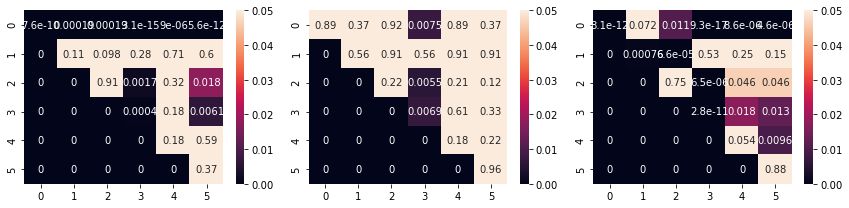

In [29]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(12,3)
sns.heatmap(train_pvals_corr,annot=True,vmax=0.05,ax = axs[0])
sns.heatmap(test_pvals_corr,annot=True,vmax=0.05,ax = axs[1])
sns.heatmap(pdbp_pvals_corr,annot=True,vmax=0.05,ax = axs[2])

fig.tight_layout()

In [30]:
df = df_train[np.isin(df_train.IniState, [0,1])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 132 total observations, 96 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 132
number of events observed = 36
   partial log-likelihood = -152.160
         time fit was run = 2021-03-25 14:42:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   1.851      6.368      0.347            1.172            2.531                3.228               12.562
TotalTime -0.112      0.894      0.052           -0.214           -0.010                0.807                0.990

               z       p   -log2(p)
covariate                          
IniState   5.340 <0.0005     23.358
TotalTime -2.151   0.031      4.991
---
Concordance = 0.745
Partial AIC = 308.321
log-likelihood ratio test = 33.537 on 2 df
-log2(p) of ll-ratio test = 24.192

In [31]:
df = df_train[np.isin(df_train.IniState, [0,2])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 144 total observations, 112 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 32
   partial log-likelihood = -146.938
         time fit was run = 2021-03-25 14:42:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   0.639      1.894      0.179            0.288            0.989                1.334                2.689
TotalTime  0.048      1.050      0.106           -0.159            0.256                0.853                1.292

              z       p   -log2(p)
covariate                         
IniState  3.574 <0.0005     11.472
TotalTime 0.458   0.647      0.629
---
Concordance = 0.651
Partial AIC = 297.877
log-likelihood ratio test = 12.699 on 2 df
-log2(p) of ll-ratio test = 9.160

In [32]:
df = df_train[np.isin(df_train.IniState, [0,3])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 162 total observations, 125 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 37
   partial log-likelihood = -172.585
         time fit was run = 2021-03-25 14:42:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   0.364      1.439      0.116            0.137            0.591                1.147                1.806
TotalTime -0.100      0.904      0.046           -0.191           -0.010                0.826                0.990

               z     p   -log2(p)
covariate                        
IniState   3.142 0.002      9.221
TotalTime -2.166 0.030      5.046
---
Concordance = 0.686
Partial AIC = 349.169
log-likelihood ratio test = 16.785 on 2 df
-log2(p) of ll-ratio test = 12.108

In [33]:
df = df_pdbp[np.isin(df_pdbp.IniState, [0,1])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 167 total observations, 151 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 167
number of events observed = 16
   partial log-likelihood = -64.991
         time fit was run = 2021-03-25 14:42:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   2.910     18.364      0.523            1.886            3.935                6.594               51.145
TotalTime  0.667      1.948      0.523           -0.358            1.692                0.699                5.432

              z       p   -log2(p)
covariate                         
IniState  5.569 <0.0005     25.219
TotalTime 1.275   0.202      2.305
---
Concordance = 0.796
Partial AIC = 133.982
log-likelihood ratio test = 30.295 on 2 df
-log2(p) of ll-ratio test = 21.854

In [34]:
df = df_pdbp[np.isin(df_pdbp.IniState, [0,2])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 201 total observations, 189 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 201
number of events observed = 12
   partial log-likelihood = -59.961
         time fit was run = 2021-03-25 14:42:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   0.468      1.598      0.289           -0.097            1.034                0.907                2.813
TotalTime 15.502  5.401e+06   2848.434        -5567.326         5598.330                0.000                  inf

              z     p   -log2(p)
covariate                       
IniState  1.623 0.105      3.256
TotalTime 0.005 0.996      0.006
---
Concordance = 0.664
Partial AIC = 123.922
log-likelihood ratio test = 5.884 on 2 df
-log2(p) of ll-ratio test = 4.244

In [35]:
df = df_pdbp[np.isin(df_pdbp.IniState, [0,3])]
cph = CoxPHFitter()
cph.fit(df,'TT7', 'observed')
cph.print_summary(decimals=3)

<lifelines.CoxPHFitter: fitted with 312 total observations, 285 right-censored observations>
             duration col = 'TT7'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 312
number of events observed = 27
   partial log-likelihood = -148.478
         time fit was run = 2021-03-25 14:42:40 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IniState   0.394      1.483      0.155            0.091            0.698                1.095                2.009
TotalTime -0.176      0.839      0.109           -0.390            0.038                0.677                1.038

               z     p   -log2(p)
covariate                        
IniState   2.548 0.011      6.528
TotalTime -1.616 0.106      3.235
---
Concordance = 0.645
Partial AIC = 300.955
log-likelihood ratio test = 9.316 on 2 df
-log2(p) of ll-ratio test = 6.720